In [2]:
import numpy as np
import pandas as pd
import zipfile
import os
import yaml
import glob
import torch
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
from data import make_data
from autoencoder import Autoencoder

In [3]:
config_path = "configs/layer10_batch_size1028.yaml"
checkpoint_path = "results/layer10_batch_size1028-epoch=024.ckpt"

config = yaml.safe_load(open(config_path, "r"))

print("Loading the saved model")
# initialize the autoencoder class
model = Autoencoder(patch_size=config["data"]["patch_size"], **config["autoencoder"])
# tell PyTorch to load the model onto the CPU if no GPU is available
map_location = None if torch.cuda.is_available() else 'cpu'
# load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=map_location)
# load the checkpoint's state_dict into the model
model.load_state_dict(checkpoint["state_dict"])
# put the model in evaluation mode
model.eval()

Loading the saved model


Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=648, out_features=256, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=128, out_features=256, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8)

In [4]:
data_dict = {}
for file in os.listdir("../data/"):
    if file.endswith(".npz"):
        file_path = os.path.join("../data/", file)
        data = np.load(file_path)
        data_dict[file] = {name: data[name] for name in data.files}

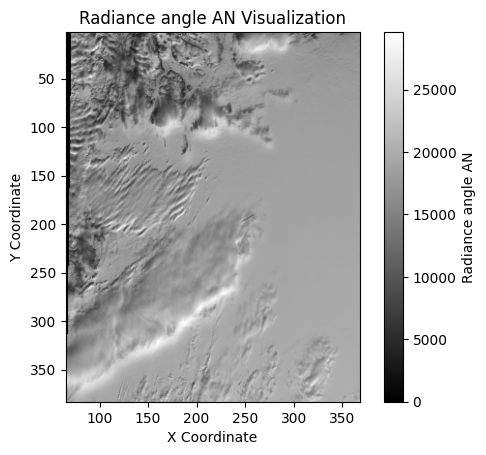

In [5]:
# Extract relevant columns
arr = data_dict["O012791.npz"]["arr_0"]
x = arr[:, 1]  # x-coordinate
y = arr[:, 0]  # y-coordinate
an = arr[:, -2]  # Radiance angle AN

# Create grid for image
x_unique = np.unique(x)
y_unique = np.unique(y)

# Reshape Radiance angle AN to fit the grid
an_grid = np.zeros((len(y_unique), len(x_unique)))

for i in range(len(x)):
    x_idx = np.where(x_unique == x[i])[0][0]
    y_idx = np.where(y_unique == y[i])[0][0]
    an_grid[y_idx, x_idx] = an[i]

# Plot Radiance angle AN as a heatmap
plt.imshow(an_grid, cmap='gray', extent=[x.min(), x.max(), y.max(), y.min()])
plt.colorbar(label='Radiance angle AN')
plt.title('Radiance angle AN Visualization')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


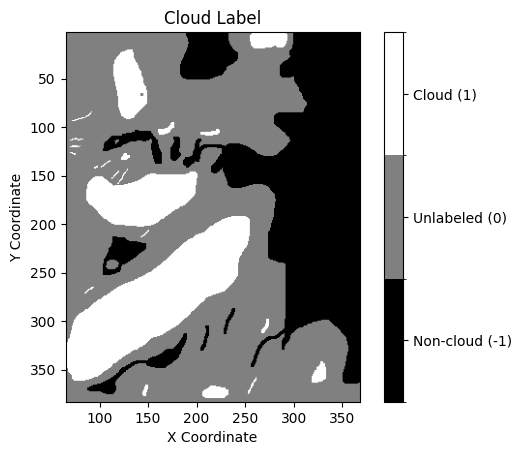

In [8]:
# Extract relevant columns
x = arr[:, 1]  # x-coordinate
y = arr[:, 0]  # y-coordinate
cloud = arr[:, -1]

# Create grid for image
x_unique = np.unique(x)
y_unique = np.unique(y)

# Reshape Cloud Label to fit the grid
cloud_grid = np.zeros((len(y_unique), len(x_unique)))

for i in range(len(x)):
    x_idx = np.where(x_unique == x[i])[0][0]
    y_idx = np.where(y_unique == y[i])[0][0]
    cloud_grid[y_idx, x_idx] = cloud[i]

cmap = plt.cm.colors.ListedColormap(["black", "grey", "white"])
bounds = [-1.5, -0.5, 0.5, 1.5]  # Define boundaries for labels
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

# Plot Cloud Label as a heatmap
plt.imshow(cloud_grid, cmap=cmap, norm=norm, extent=[x.min(), x.max(), y.max(), y.min()])
cbar = plt.colorbar()
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(["Non-cloud (-1)", "Unlabeled (0)", "Cloud (1)"])
plt.title('Cloud Label')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [20]:
# only get patches for the three labeled images
images_long, patches = make_data(patch_size=config["data"]["patch_size"])

print("Obtaining embeddings")
# get the embedding for each patch
embeddings = []  # what we will save
images_embedded = []  # for visualization

for i in tqdm(range(len(images_long))):
    ys = images_long[i][:, 0]
    xs = images_long[i][:, 1]

    # determine the height and width of the image
    miny = min(ys)
    minx = min(xs)
    height = int(max(ys) - miny + 1)
    width = int(max(xs) - minx + 1)

    # to make this faster, we use torch.no_grad() to disable gradient tracking
    with torch.no_grad():
        # get the embedding of array of patches
        emb = model.embed(torch.tensor(np.array(patches[i])))
        # in the following line we:
        # - detach the tensor from the computation graph
        # - move it to the cpu
        # - turn it into a numpy array
        emb = emb.detach().cpu().numpy()

    embeddings.append(emb)

    # represent the embedding as an image, if you want
    img_embedded = np.zeros((emb.shape[1], height, width))
    img_embedded[:, (ys - miny).astype(int), (xs - minx).astype(int)] = emb.T
    images_embedded.append(img_embedded)

print("Saving the embeddings")
# save the embeddings as csv
for i in tqdm(range(len(images_long))):
    embedding_df = pd.DataFrame(embeddings[i], columns=[f"ae{i}" for i in range(50)])
    embedding_df["y"] = images_long[i][:, 0]
    embedding_df["x"] = images_long[i][:, 1]
    # move y and x to front
    cols = embedding_df.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    embedding_df = embedding_df[cols]
    # save to csv
    embedding_df.to_csv(f"../data/layer10_batch_size1028/image{i+1}_ae.csv", index=False)

done reshaping images
working on image 0
Obtaining embeddings


100%|██████████| 1/1 [00:30<00:00, 30.02s/it]


Saving the embeddings


100%|██████████| 1/1 [00:06<00:00,  6.94s/it]


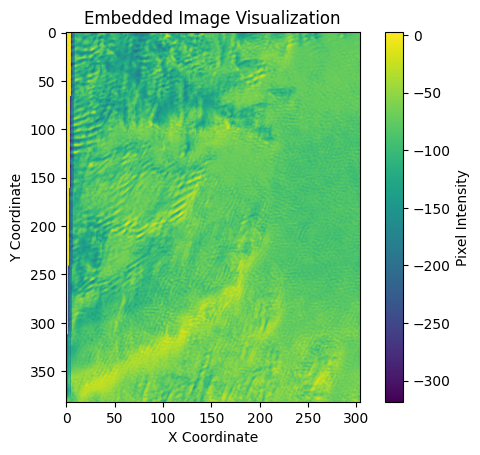

In [ ]:
image_to_plot = images_embedded[0][0]

# Plot the Embedded image
plt.imshow(image_to_plot)
cbar = plt.colorbar()
cbar.set_label('Pixel Intensity')  # Update the label if needed

# Set titles and axis labels
plt.title('Embedded Image Visualization')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Show the plot
plt.show()